<p align="center">
  <img src="https://cimss.ssec.wisc.edu/satellite-blog/wp-content/uploads/sites/5/2025/01/Untitled-1-1.gif" alt="High Resolution Views of a Lake Michigan Winter (https://cimss.ssec.wisc.edu/satellite-blog/archives/62929)" />
</p>

# Wave Height from Station 44013

---

## Overview
Generating a wavelet power spectrum from the time-series data [from wave heights from station 44013 East of Boston](https://www.ndbc.noaa.gov/station_history.php?station=44013) from 1992-2003

1. Prerequisties
2. Background
3. Download and Organize Buoy Data
4. Wavelet Input Values
5. PyWavelets
6. Power Spectrum

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Used to plot data |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html)| Necessary | Used to work with large arrays |

- **Time to learn**: 35 minutes

---

## Background

TODO

### Wavelets and Wave Height Data

TODO

## Imports

In [1]:
import numpy as np                          # working with arrays
import pandas as pd                         # working with dataframes
import matplotlib.pyplot as plt             # plot data
import datetime                             # converting strings to datetime objects
import requests                             # retrieve data from text on a website

import pywt                                 # PyWavelets

## Access Buoy Data

We will be downloading the buoy data data from NOAA National Data Buoy Center with contains information about the buoy

The only columns we need to keep are related to datetimes (`YY`, `MM`, `DD`, `hh`) and wave height (`WVHT`)

In [26]:
years = [2001, 2002]
for i, year in enumerate(years):
    print(year)
    lm_data_link = f"https://www.ndbc.noaa.gov/view_text_file.php?filename=41001h{year}.txt.gz&dir=data/historical/stdmet/"
    lm_data_req = requests.get(lm_data_link)
    lm_data_txt = lm_data_req.text
    lm_data = np.genfromtxt(lm_data_txt.splitlines(), comments=None, dtype='str')
    datetime_index = np.where(lm_data[0] == "hh")[0][0]
    wave_height_index = np.where(lm_data[0] == "WVHT")[0][0]
    
    # colelct date data from full datset
    lm_datetime = lm_data[:,:datetime_index+1][1:]
    print(lm_datetime[0])
    lm_wave_height = lm_data[:,wave_height_index][1:] # skip first header row
    print(lm_wave_height)
    lm_wave_height = lm_wave_height.astype(float)

    if i == 1:
        date_times = lm_datetime
        wave_height = lm_wave_height
    else:
        date_times = np.concatenate([date_times, lm_datetime])
        wave_height = np.concatenate([wave_height, lm_wave_height])
    # collect wave height data from full dataset
    # convert array of strings to array of floats
    

print(date_times.shape)
print(wave_height.shape)

2001
['2001' '01' '01' '00']
['3.26' '3.11' '2.81' ... '1.39' '1.28' '1.27']
2002
['2002' '01' '01' '00']
['1.29' '1.25' '1.17' ... '2.42' '2.14' '2.20']
(8421, 4)
(8421,)


## Clean Up Wave Height data
#Buoy stores null data as 99.00, so we will replace 99.00 with nan

In [27]:
print(max(wave_height))
wave_height = np.where(wave_height == 99.00, np.nan, wave_height)
print(max(wave_height))

99.0
8.33


## Convert Time to Datetimes

Buoy stores datetime information as seperate columns of data, let's convert this into a datetime object

In [28]:
# YYYY MM DD HH
dates = []
for date in date_times:
    date_string = "".join(date)
    dates.append(datetime.datetime.strptime(date_string, "%Y%m%d%H"))
dates = np.array(dates)
print(f"First Date = {dates[0]}")
print(f"Last Date = {dates[-1]}")

First Date = 2002-01-01 00:00:00
Last Date = 2002-12-17 20:00:00


## Plot and View Data

Let's give the data a look! We will be looking at about four months worth of buoy data

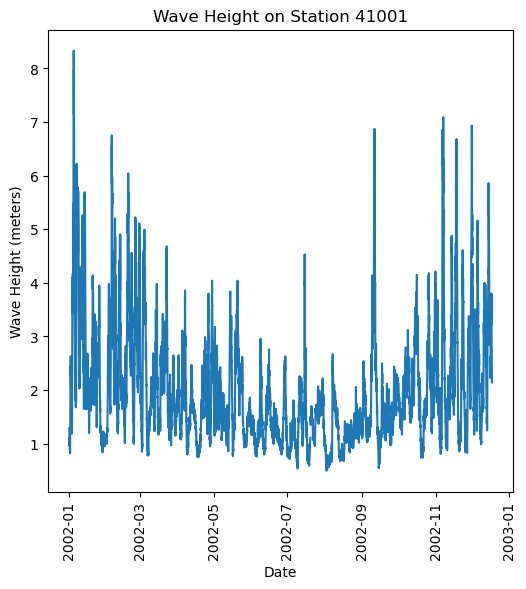

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Wave Height on Station 41001")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Wave Height (meters)")
plt.plot(dates, wave_height)
plt.show()

## Wavelet Input Values

Wavelet inputs include:

- x: Input time-series data (for example, the time and wave height of data)
- wavelet: mother wavelet name
- dt: sampling period (time between each y-value)
- s0: smallest scale
- dj: spacing between each discrete scales
- jtot: largest scale

In [30]:
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 64  # largest scale

**For this example, we will be using a complex Morlet with a bandwidth of 1.5 and a center frequency of 1**

In [31]:
bandwidth = 1.5
center_freq = 1
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.5-1


## Applying Wavelets

[16567.055       2975.86339165   467.19337814 ...   317.48804415
   467.19337814  2975.86339165]
[ 0.          0.00011875  0.0002375  ... -0.00035625 -0.0002375
 -0.00011875]


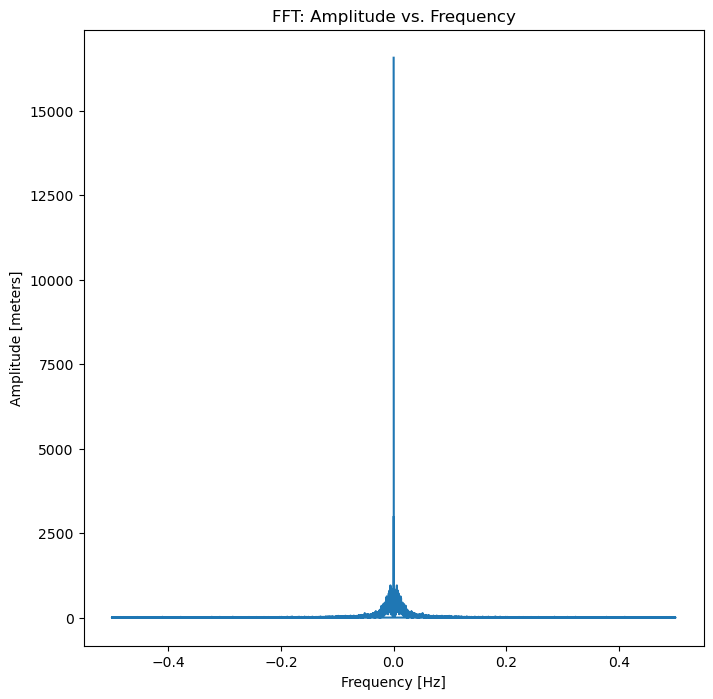

In [37]:
#from scipy.fftpack import fft, fftfreq      # working with Fourier Transforms

lm_len = np.arange(len(wave_height))
mask = np.isfinite(wave_height)
xfiltered = np.interp(lm_len, lm_len[mask], wave_height[mask])
fft_mag = np.abs(np.fft.fft(xfiltered)) # estimated amplitude
fft_freq = np.fft.fftfreq(len(wave_height))
print(fft_mag)
print(fft_freq)

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(fft_freq, fft_mag)
plt.title("FFT: Amplitude vs. Frequency")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [meters]")
plt.show()

In [38]:
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=xfiltered, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)

f = pywt.scale2frequency(wavelet_mother, scales)/dt
#print(f)

## Power Spectrum
The power spectrum is the real component of the wavelet coefficients. We can find this value by squaring the absolute value of the `wavelet_coeffs` to return the magnitude of the real component to make a better graph.

In [39]:
power = np.power((abs(wavelet_coeffs)), 2)

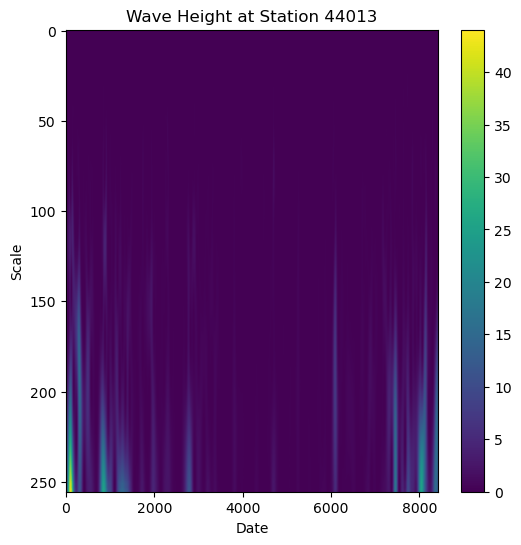

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), aspect="auto"
)

plt.title("Wave Height at Station 44013")
plt.xlabel("Date")
plt.ylabel("Scale")
#ax.set_xlim([dates[0], dates[-1]])
plt.colorbar()
plt.show()

The power spectrum above demonstrates a strong peak (in yellow) at  ...[TODO]

---

## Summary
TODO

### What's next?

- [Learn how more about PyWavelets](https://pywavelets.readthedocs.io/en/latest/regression/index.html)


## Resources and references

- ["A Practical Guide to Wavelet Analysis" (Torrence and Compo, 1998)](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf)